In [6]:
import botorch
from known_boundary.acquisition_function import EI,SLogEI,EI_acquisition_opt,MES_acquisition_opt,LCB_acquisition_opt,ERM_acquisition_opt,SLogTEI_acquisition_opt,SLogEI_acquisition_opt
from known_boundary.utlis import  get_initial_points,transform,opt_model_MLE,opt_model_MAP
import numpy as np
import GPy
import torch
from botorch.test_functions import Ackley,Beale,Branin,Rosenbrock,SixHumpCamel,Hartmann,Powell,DixonPrice,Levy,StyblinskiTang,Griewank
import obj_functions.push_problems
from botorch.utils.transforms import unnormalize,normalize
from known_boundary.SLogGP import SLogGP
import scipy 
from sklearn.metrics.pairwise import euclidean_distances
from scipy.stats import norm
import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger('lengthscale').disabled = True
logging.getLogger('variance').disabled = True
logging.getLogger('psi').disabled = True


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double


function_information = []
fstar=0.397887 
distances = np.array([0.001,0.1,1,2,5,10,50,100,200])

# temp={}
# temp['name']='Branin2D' 
# temp['function'] = Branin(negate=False)
# temp['fstar'] =  0.397887 
# function_information.append(temp)

temp={}
temp['name']='Beale2D' 
temp['function'] = Beale(negate=False)
temp['fstar'] =  0.
function_information.append(temp)

# temp={}
# temp['name']='Hartmann3D' 
# temp['function'] = Hartmann(dim=3,negate=False)
# temp['fstar'] =  -3.86278
# function_information.append(temp)


# temp={}
# temp['name']='DixonPrice4D' 
# temp['function'] = DixonPrice(dim=4,negate=False)
# temp['fstar'] = 0.
# temp['min']=True 
# function_information.append(temp)

In [20]:
def EI_posteriorMean(X,dim,f_best,model,f_star='no'): # X is a 2-dimensional array because we will use it in scipy.minimize

  X = X.reshape(-1,dim)
  
  mean,var = model.predict_noiseless(X)
  

  if f_star == 'no':
      z = (f_best - mean)/np.sqrt(var)        
      out=(f_best - mean) * norm.cdf(z) 
  
  return mean,var

In [44]:
def EI_exploit(X,dim,f_best,model,f_star='no'): # X is a 2-dimensional array because we will use it in scipy.minimize

  X = X.reshape(-1,dim)
  
  mean,var = model.predict_noiseless(X)
  

  if f_star == 'no':
      z = (f_best - mean)/np.sqrt(var)        
      out=(f_best - mean) * norm.cdf(z) 
  
  return out


def EI_explore(X,dim,f_best,model,f_star='no'): # X is a 2-dimensional array because we will use it in scipy.minimize

  X = X.reshape(-1,dim)
  
  mean,var = model.predict_noiseless(X)
  

  if f_star == 'no':
      z = (f_best - mean)/np.sqrt(var)        
      out= np.sqrt(var) * norm.pdf(z)
      
  return out

In [8]:
from sklearn.metrics.pairwise import euclidean_distances

In [9]:
information = function_information[0]

In [69]:
total_record = []
total_record2 = []
total_record3 = []
total_record4 = []

for dist in distances:
    
    
    print('!!!!distance is: ',dist)
    
 

    fun = information['function']
    dim = fun.dim
    bounds = fun.bounds
    standard_bounds=np.array([0.,1.]*dim).reshape(-1,2)
    
    n_init = 4*dim

    
    # fstar = dist #information['fstar']
    
    # print('fstar is: ',fstar)
    

    step_size = 2
    iter_num = 1
    N = 40

    lengthscale_range = [0.001,2]
    variance_range = [0.001**2,20]
    noise = 1e-6
    
    print(information['name'])
    ratio_holder = []
    ratio_holder2 = []
    ratio_holder3 = []
    
    dis_holder = []
    ######################## SlogGP+logEI#######################################

    for exp in range(N):

        seed = exp
       
        print(exp)

        X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
       
       
        Y_BO = torch.tensor(
            [fun(x) for x in X_BO], dtype=dtype, device=device
        ).reshape(-1,1)



        best_record = [Y_BO.min().item()]
        np.random.seed(1234)
       
        boundarys = []
        variances = []


    
        i = 0
        print('inner loop: ',i)

        
        train_Y = Y_BO.numpy()
        
        print('so far best: ',np.min(train_Y))
        fstar = np.min(train_Y) - dist
        
        if i%step_size == 0  :
            Y_min = np.min(train_Y)
            Y_std = np.std(train_Y-Y_min)
            
        fstar_shifted = fstar -Y_min # shifted lower bound
        train_Y = train_Y - Y_min  # shift Y
        
        #scalise Y_shift and fstar_shift
        train_Y = train_Y/Y_std
        fstar_shifted = fstar_shifted/Y_std
    

        
        train_X = normalize(X_BO, bounds)
        train_X = train_X.numpy()
        
        lower = -fstar_shifted
        upper = 10**(-6)+lower
        
    
            
        c_range = [lower,upper]

        if i%step_size == 0:
            
            parameters = opt_model_MLE(train_X,train_Y,dim,'SLogGP',noise=noise,seed=i,lengthscale_range=lengthscale_range,variance_range=variance_range,c_range=c_range)                

            lengthscale = parameters[0]
            variance = parameters[1]
            c = parameters[2]
        
        print('lengthscale is ',lengthscale)
        print('variance is ',variance)
        print('lower bound is ',-c*Y_std+Y_min)
        
            
        boundarys.append(-c*Y_std+Y_min)
        variances.append(variance)
        
        
        warp_Y = np.log(train_Y+c)
        mean_warp_Y = np.mean(warp_Y) # use to predict mean
        warp_Y_standard = warp_Y-mean_warp_Y
        
        
        kernel = GPy.kern.RBF(input_dim=dim,lengthscale= lengthscale,variance=variance)  
        m = GPy.models.GPRegression(train_X, warp_Y_standard,kernel)
        m.Gaussian_noise.variance.fix(noise)
        
        np.random.seed(i)
        standard_next_X = SLogEI_acquisition_opt(model=m,bounds=standard_bounds,f_best=np.min(train_Y),c=c,
                                                f_mean=mean_warp_Y)
        
        best_idx = np.argmin(train_Y)
        best_X = train_X[best_idx]
        
        dis = euclidean_distances(standard_next_X.reshape(-1,dim),best_X.reshape(-1,dim))
        print('dis is: ',dis)
        dis_holder.append(dis)
        
        
        # check EE balance
        train_Y = Y_BO.numpy() 
        train_Y = (train_Y - np.mean(train_Y))/np.std(train_Y)
        parameters = opt_model_MLE(train_X,train_Y,dim,'GP',noise=noise,seed=i,lengthscale_range=lengthscale_range,variance_range=variance_range) 
        lengthscale = parameters[0]
        variance = parameters[1]
    
        kernel = GPy.kern.RBF(input_dim=dim,lengthscale=lengthscale,variance=variance)
        m = GPy.models.GPRegression(train_X.reshape(-1,dim), train_Y.reshape(-1,1),kernel)
        m.Gaussian_noise.fix(noise)
        
        acq_val = EI(X=standard_next_X,dim=dim,f_best=np.min(train_Y),model=m,f_star='no')
        PM,PV = EI_posteriorMean(X=standard_next_X,dim=dim,f_best=np.min(train_Y),model=m,f_star='no')
        
        #ratio = acq_val_exploitation/acq_val
        ratio_holder.append(PM[0][0])
        print('mean is: ',PM)
        ratio_holder2.append(PV[0][0])
        print('variance is: ',PV)
        
        
        acq_explore = EI_explore(X=standard_next_X,dim=dim,f_best=np.min(train_Y),model=m,f_star='no') [0][0]
        ratio = acq_explore/acq_val
        ratio_holder3.append(ratio)
        print('ratio is: ',acq_explore)
        
        # mean,var = m.predict_noiseless(standard_next_X.reshape(-1,dim))
        # f_best = np.min(train_Y)
        # z = (f_best - mean)/np.sqrt(var)        
        # out=(f_best - mean) * norm.cdf(z)
        # ratio = out/acq_val[0]
        # ratio_holder.append(ratio)
        # print('acquisition is ',acq_val[0])
        # print('exploit is ',out)
        # print('ratio is: ',ratio)
    #     acq_val = SLogEI(X=standard_next_X,dim=dim,f_best=np.min(train_Y),c=c,f_mean=mean_warp_Y,model=m)
    #     mean,var = m.predict_noiseless(standard_next_X.reshape(-1,dim))
    #     mu = mean+mean_warp_Y
    #     predictMean = np.exp(mu+0.5*var)-c
    #     print('mean is ',predictMean)
    #     print('so far best is: ',np.min(train_Y) )
    #     print('acqusition is: ',acq_val)
    #     ratio = (np.min(train_Y) - predictMean)/acq_val
    #     ratio_holder.append(ratio)
    
    total_record4.append(ratio_holder3)
    total_record3.append(ratio_holder2)
    total_record2.append(ratio_holder)
    total_record.append(dis_holder)
   
        


!!!!distance is:  0.001
Beale2D
0
inner loop:  0
so far best:  15.13676229946356
lengthscale is  0.160363089637974
variance is  20.0
lower bound is  15.135762299463561
dis is:  [[0.03065441]]
mean is:  [[-0.61945465]]
variance is:  [[0.00378932]]
ratio is:  0.024303642172435715
1
inner loop:  0
so far best:  19.48512006289873
lengthscale is  0.05321107253103994
variance is  19.999999712726517
lower bound is  19.484120062894092
dis is:  [[0.03089724]]
mean is:  [[-0.40109448]]
variance is:  [[0.00148483]]
ratio is:  0.0003205226822741477
2
inner loop:  0
so far best:  6.802468539619835
lengthscale is  0.0010188164919579686
variance is  19.99999999993916
lower bound is  6.801468539619835
dis is:  [[0.35205677]]
mean is:  [[-0.74665297]]
variance is:  [[0.10612771]]
ratio is:  0.11513012751916693
3
inner loop:  0
so far best:  14.34859887684805
lengthscale is  0.13361826800877769
variance is  20.0
lower bound is  14.34759887684742
dis is:  [[0.05295303]]
mean is:  [[-0.0360382]]
variance 

{'whiskers': [<matplotlib.lines.Line2D at 0x7fde654ca3d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fde654caaf0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fde654ca040>,
 'medians': [<matplotlib.lines.Line2D at 0x7fde654ef250>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fde654ef5e0>,
 'means': []}

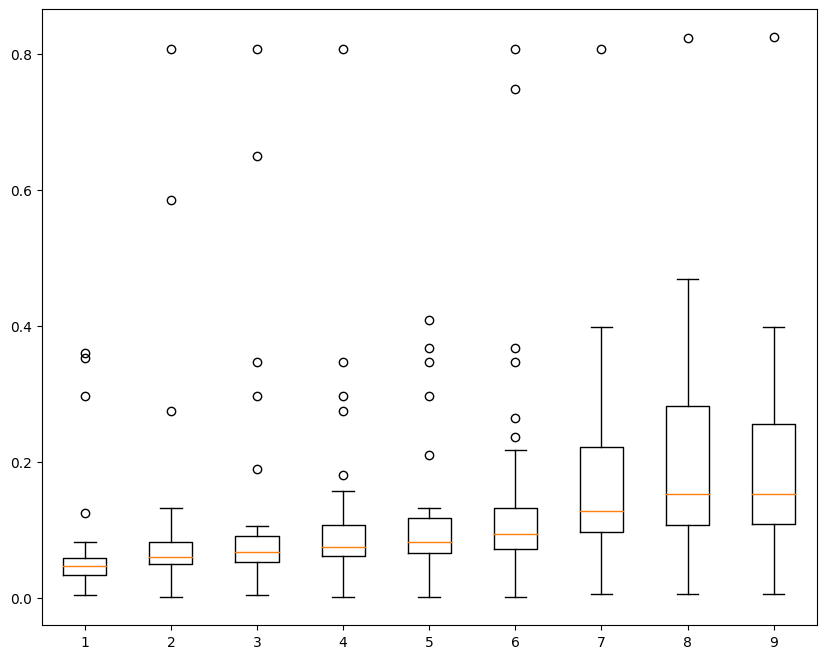

In [73]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import os


aa = (np.array(total_record).reshape(-1,40))

# Creating dataset
np.random.seed(10)
 

fig = plt.figure(figsize =(10, 8))
 
# Creating plot
plt.boxplot(aa.T)

# plt.xticks([1, 2, 3, 4,5,6,7,8,9], predefined_labels)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fde656972b0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fde656979d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fde6567fe80>,
 'medians': [<matplotlib.lines.Line2D at 0x7fde656a2130>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fde656a24c0>,
 'means': []}

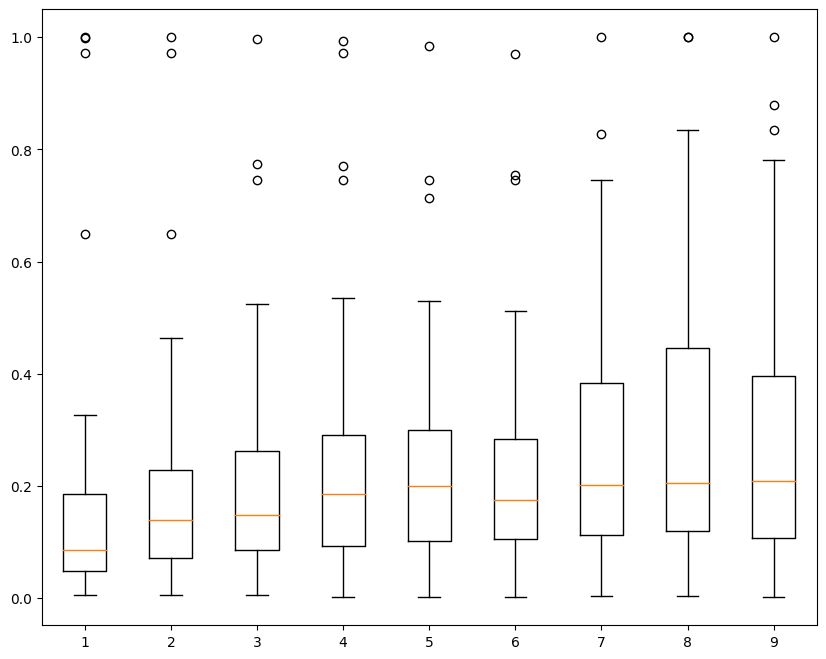

In [74]:
aa = np.sqrt(np.array(total_record3).reshape(-1,40))

# Creating dataset
np.random.seed(10)
 

fig = plt.figure(figsize =(10, 8))
 
# Creating plot
plt.boxplot(aa.T)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fde65966670>,
 'caps': [<matplotlib.lines.Line2D at 0x7fde65966d90>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fde659662e0>,
 'medians': [<matplotlib.lines.Line2D at 0x7fde6581e4f0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fde6581e880>,
 'means': []}

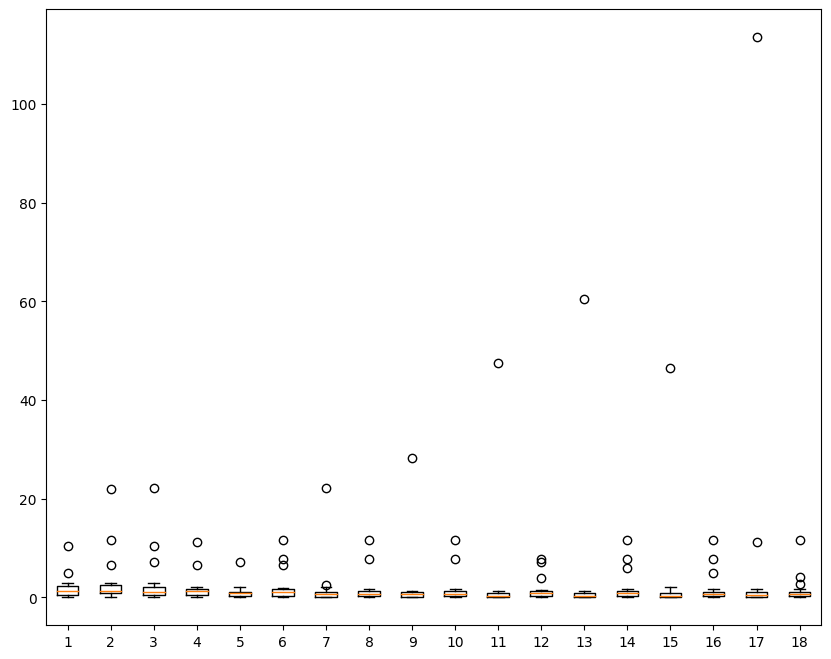

In [75]:
aa = (np.array(total_record4).reshape(-1,20))

# Creating dataset
np.random.seed(10)
 

fig = plt.figure(figsize =(10, 8))
 
# Creating plot
plt.boxplot(aa.T)

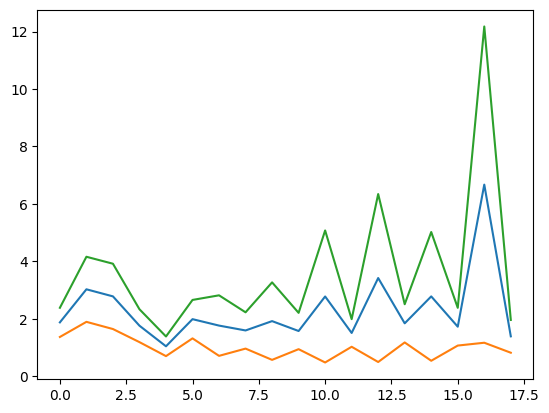

In [76]:
aa = (np.array(total_record4).reshape(-1,20))

plt.plot(np.mean(aa,1))
plt.plot(np.mean(aa,1)-np.std(aa,1)/np.sqrt(20))
plt.plot(np.mean(aa,1)+np.std(aa,1)/np.sqrt(20))

In [65]:
aa[0]

array([1.19294662e+00, 1.02974950e+01, 5.10328496e-01, 2.11072429e+00,
       1.35819556e+00, 5.43588557e-03, 2.71977529e+00, 2.96869723e+00,
       5.30602481e-02, 7.27204793e-03, 1.14131428e+00, 1.27796811e+00,
       2.15294901e+00, 1.11899302e+00, 3.73030647e-04, 2.19117419e-01,
       2.37118786e+00, 4.86883264e+00, 1.94769568e+00, 1.15347920e+00])

# plot

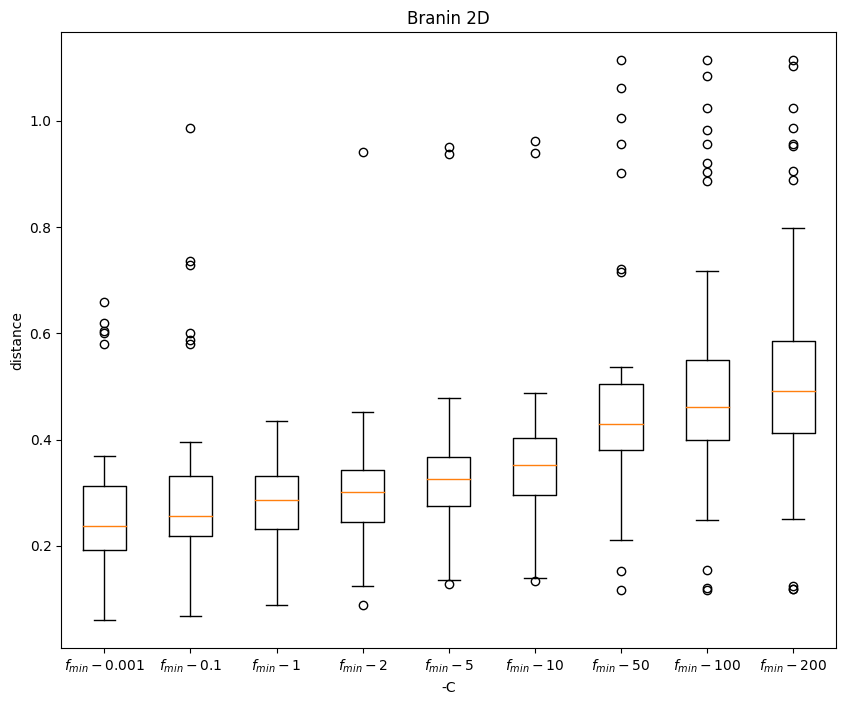

In [11]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import os
total_record = np.genfromtxt(os.path.join(os.getcwd(),'distance/Branin2D_SLogGP+logEI_distance'), delimiter=',')

aa = np.sqrt(np.array(total_record).reshape(-1,50))

# Creating dataset
np.random.seed(10)
 

predefined_labels = ['$f_{min}-0.001$', '$f_{min}-0.1$', '$f_{min}-1$', '$f_{min}-2$',
                     '$f_{min}-5$','$f_{min}-10$','$f_{min}-50$','$f_{min}-100$','$f_{min}-200$']
fig = plt.figure(figsize =(10, 8))
 
# Creating axes instance
#ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
plt.boxplot(aa.T)

plt.xticks([1, 2, 3, 4,5,6,7,8,9], predefined_labels)
 
# show plot
plt.xlabel('-C')
plt.ylabel('distance')
plt.title('Branin 2D')


plt.savefig('plots/Branin_distance.png')

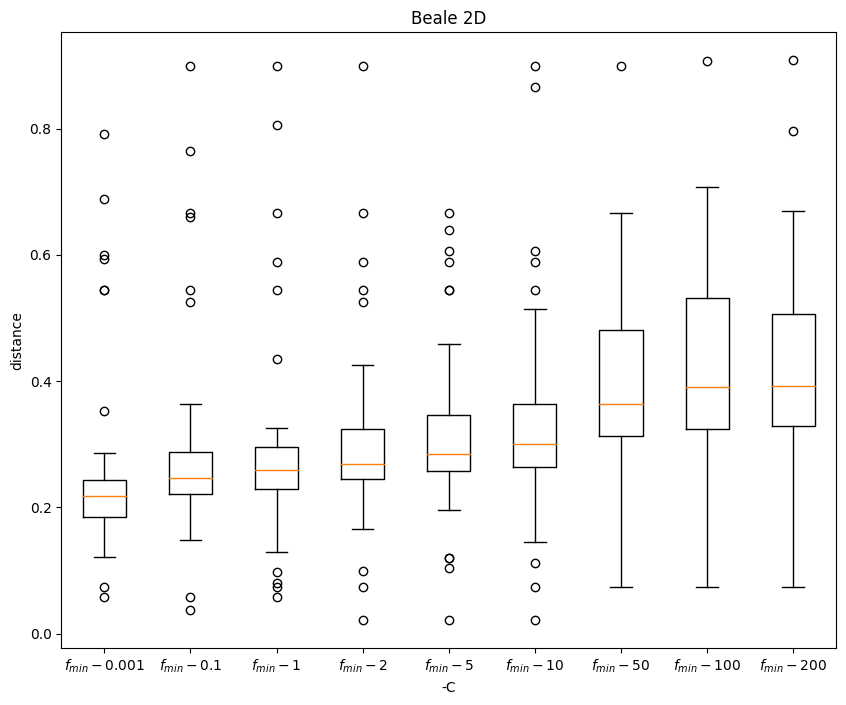

In [9]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import os
total_record = np.genfromtxt(os.path.join(os.getcwd(),'distance/Beale2D_SLogGP+logEI_distance'), delimiter=',')

aa = np.sqrt(np.array(total_record).reshape(-1,50))

# Creating dataset
np.random.seed(10)
 

predefined_labels = ['$f_{min}-0.001$', '$f_{min}-0.1$', '$f_{min}-1$', '$f_{min}-2$',
                     '$f_{min}-5$','$f_{min}-10$','$f_{min}-50$','$f_{min}-100$','$f_{min}-200$']
fig = plt.figure(figsize =(10, 8))
 
# Creating axes instance
#ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
plt.boxplot(aa.T)

plt.xticks([1, 2, 3, 4,5,6,7,8,9], predefined_labels)
 
# show plot
plt.xlabel('-C')
plt.ylabel('distance')
plt.title('Beale 2D')

plt.savefig('plots/Beale_distance.png')

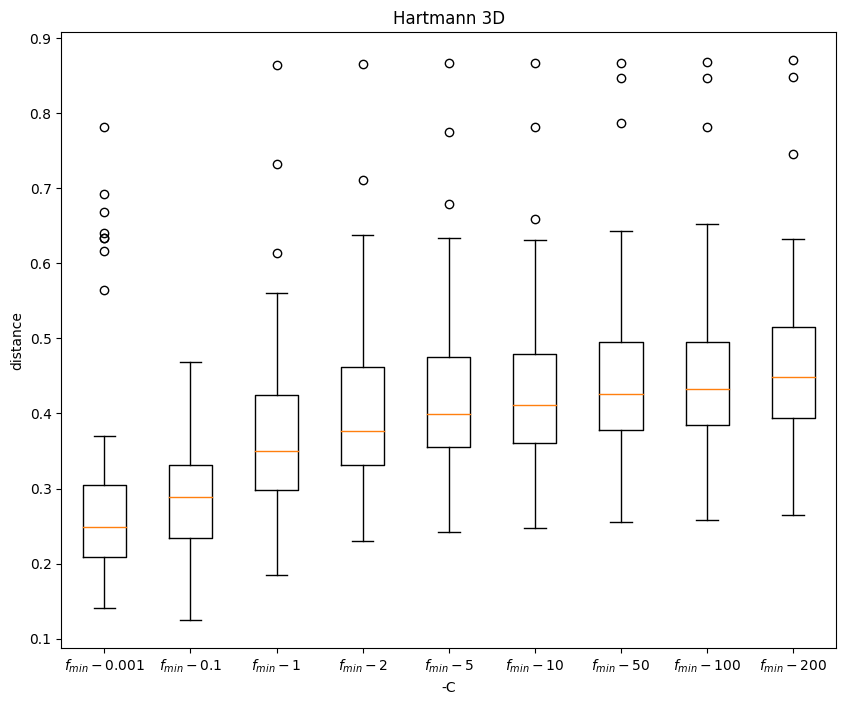

In [14]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import os
total_record = np.genfromtxt(os.path.join(os.getcwd(),'distance/Hartmann3D_SLogGP+logEI_distance'), delimiter=',')

aa = np.sqrt(np.array(total_record).reshape(-1,50))

# Creating dataset
np.random.seed(10)
 

predefined_labels = ['$f_{min}-0.001$', '$f_{min}-0.1$', '$f_{min}-1$', '$f_{min}-2$',
                     '$f_{min}-5$','$f_{min}-10$','$f_{min}-50$','$f_{min}-100$','$f_{min}-200$']
fig = plt.figure(figsize =(10, 8))
 
# Creating axes instance
#ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
plt.boxplot(aa.T)

plt.xticks([1, 2, 3, 4,5,6,7,8,9], predefined_labels)
 
# show plot
plt.xlabel('-C')
plt.ylabel('distance')
plt.title('Hartmann 3D')

plt.savefig('plots/Hartmann_distance.png')